`gg-napari-env`

In [2]:
import napari
from napari_czifile2 import napari_get_reader
from cellpose import models, plot, utils, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours
import pandas as pd
import skimage.exposure as exposure
from skimage.morphology import remove_small_objects
import numpy as np
from skimage.measure import label, regionprops
import seaborn as sns
import os 
import sys 
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion, gaussian_filter, binary_dilation, binary_fill_holes
from skimage import exposure
import sys 
from plotting import * 
white_plotting()
import warnings
import matplotlib.font_manager as fm
fm.fontManager.__init__()
warnings.filterwarnings("ignore")
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

Initializing plotting package
>>> GPU activated? 1
2025-03-26 15:35:01,971 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-03-26 15:35:01,972 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

## 9E198-B3-488 & 9E197-B1-546 & 9E196-B2-647 & DAPI

In [24]:
input = '20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi'
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('.csv')]

# Load all results 
results = pd.DataFrame() 
for f in results_files:
    results_path = os.path.join(results_dir, f)
    results = pd.concat([results, pd.read_csv(results_path)], axis=0) 

results

z_id                              image   z  count      area  \
0         1  20250325 5 t35 sample 4 great.czi   8      0  7.508151   
1         2  20250325 5 t35 sample 4 great.czi   8      1  7.574679   
2         1  20250325 5 t35 sample 4 great.czi   9      2  9.513493   
3         2  20250325 5 t35 sample 4 great.czi   9      3  7.089976   
4         1  20250325 5 t35 sample 4 great.czi  10      4  6.833368   
...     ...                                ...  ..    ...       ...   
32457     7  20250325 5 t35 sample 1 great.czi  84  32457  5.607353   
32458     8  20250325 5 t35 sample 1 great.czi  84  32458  4.799514   
32459     1  20250325 5 t35 sample 1 great.czi  85  32459  6.899896   
32460     2  20250325 5 t35 sample 1 great.czi  85  32460  8.258966   
32461     3  20250325 5 t35 sample 1 great.czi  85  32461  7.831287   

       centroid_x   centroid_y  AF546-T1   AF488-T2  AF647-T3  
0      636.105063  1543.531646  1.654430  11.756962  2.160759  
1      683.987453  1587.579674  1.848181  10.797992  2.249686  
2      668.364635  1544.600400  1.620380  10.666334  2.098901  
3      639.257373  1545.315013  1.615282   9.958445  1.903485  
4      784.157163  1269.901252  1.606398   9.823366  1.958275  
...           ...          ...       ...        ...       ...  
32457  691.859322   951.608475  1.400000   6.101695  1.805085  
32458  740.348515   955.007921  1.506931   6.405941  2.300990  
32459  668.389807   899.117080  1.387052   6.079890  1.487603  
32460  700.422325   903.955121  1.767549   6.852704  2.571922  
32461  714.859223   927.037621  1.376214   5.979369  2.463592  

[122663 rows x 10 columns]

In [25]:
results.columns = results.columns.str.split('-T').str[0]

In [26]:
file_number = 1
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../raw-data/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 2 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 102, 4, 2048, 2048)
Loaded ../results/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 2 great_rois.npy


In [54]:
AF488_name, AF546_name, AF647_name = "9E198", "9E197", "9E196"
channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]

In [50]:
# Drop outliers from AF546, AF647, and AF488 columns (extremely large values) 
results = results[results['AF488']<70]

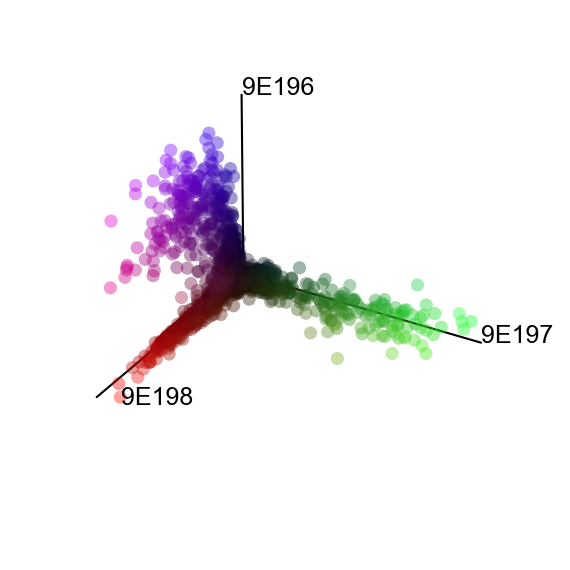

In [75]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assume AF488_name, AF546_name, and AF647_name are defined (e.g., "AF488", etc.)

# Normalize each intensity column to the [0, 1] range for natural RGB mapping
results['AF488_norm'] = (results["AF488"] - results["AF488"].min()) / (results["AF488"].max() - results["AF488"].min())
results['AF546_norm'] = (results["AF546"] - results["AF546"].min()) / (results["AF546"].max() - results["AF546"].min())
results['AF647_norm'] = (results["AF647"] - results["AF647"].min()) / (results["AF647"].max() - results["AF647"].min())
results["color"] = np.column_stack((results['AF488_norm'], results['AF546_norm'], results['AF647_norm'])).tolist()

# Optionally, you can also scale your data (if needed for other analysis) but here we use raw intensities for plotting.
# If you have already scaled data for clustering, you might want to keep the original intensity ranges for color.
# In this example, we use the original intensity values for the 3D coordinates.
fig = plt.figure(figsize=(3, 2), dpi=300) 
ax = fig.add_subplot(projection='3d')

# Plot the data using the composite RGB colors
scatter = ax.scatter(results["AF488_norm"], results["AF546_norm"], results["AF647_norm"],
                     c=results["color"], alpha=0.4, s=10, linewidths=0)

ax.text(x=1, y=0.1, z=0, s=AF488_name, fontsize=6)
ax.text(x=0, y=1, z=0, s=AF546_name, fontsize=6)
ax.text(x=0, y=0, z=1, s=AF647_name, fontsize=6)

# Draw axes lines from (0,0,0) to the max of each channel
ax.plot([0, 0], [0, 0], [0, 1], color='black', linewidth=0.5)
ax.plot([0, 0], [0, 1], [0, 0], color='black', linewidth=0.5)
ax.plot([1, 0], [0, 0], [0, 0], color='black', linewidth=0.5)

# Adjust the view so that (0,0,0) appears at the back corner.
ax.view_init(elev=30, azim=30) 

ax.set_axis_off()

plt.tight_layout()
plt.show()

In [55]:
dapi_max, AF488_max, AF546_max, AF647_max, = 255, 255, 255, 255
pixel_bounds = 125 
bbox_expansion = 5 
x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

In [ ]:

# Coordinates: on the image its up, right, left 
# 9E196, 9E197, 9E198 
coordinates = [[0, 0, 0], 
               [0.2, 0.8, 0.2], # 9E197 cytoplasmic, 9E198 nuclear, 9E196 nuclear  
               [0.8, 0, 0.2], # 9E196 cytoplasmic, 9E198 nuclear, 9E197 absent 
               [0.8, 0, 0.2], # 9E198 cytoplasmic, 9E196 nuclear, 9E197 absent
               [1, 1, 1], 
               [0.5, 0, 0], 
               
               ]
results_image = results[results['image'] == image].reset_index(drop=True)
# For each coordinate in cells_to_plot, find the closest cell in the results_image dataframe, save it to a list
cells = [] 
for coor in coordinates: 
    # Find the closest cell to the coordinate by comparing the Euclidean distance of each cell's coordinates to the target coordinate
    cell_idx = np.argmin(np.linalg.norm(results_image[["AF488_norm", "AF546_norm", "AF647_norm"]].values - coor, axis=1))
    cell = results_image.iloc[cell_idx]
    cells.append(cell)
cells = pd.DataFrame(cells)
cells

z_id                              image   z  count      area  \
14601   388  20250325 5 t35 sample 2 great.czi  39  14602  4.124731   
21363   352  20250325 5 t35 sample 2 great.czi  54  21364  7.070968   
3540    234  20250325 5 t35 sample 2 great.czi  18   3540  5.037114   
9801    488  20250325 5 t35 sample 2 great.czi  29   9802  6.567256   
14472   250  20250325 5 t35 sample 2 great.czi  39  14473  6.776344   

        centroid_x   centroid_y      AF546      AF488       AF647  AF488_norm  \
14601  1400.232719  1051.804147   1.020737   2.596774    1.115207    0.010151   
21363   537.625000  1051.530914  60.759409  10.077957   17.268817    0.178959   
3540    517.637736  1018.549057   2.428302  30.243396  109.041509    0.633977   
9801    767.305355  1135.952243   1.296671  24.903039    2.329957    0.513476   
14472   659.326788   899.270687   1.401122  20.617111   54.103787    0.416767   

       AF546_norm  AF647_norm  \
14601    0.001044    0.003332   
21363    0.869701    0.141229   
3540     0.021512    0.924655   
9801     0.005057    0.013702   
14472    0.006575    0.455674   

                                                   color  
14601  [0.010151435125072189, 0.001044343565326487, 0...  
21363  [0.17895882186596915, 0.8697006937288968, 0.14...  
3540   [0.6339771248628839, 0.021511653381058014, 0.9...  
9801   [0.5134758939995947, 0.005056685288915665, 0.0...  
14472  [0.4167670751520211, 0.006575494016894634, 0.4...

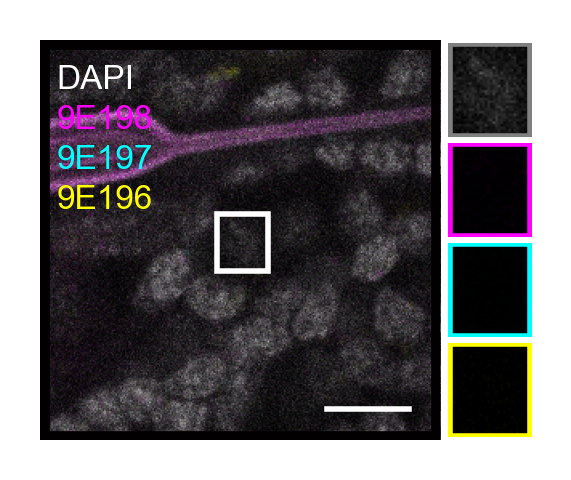

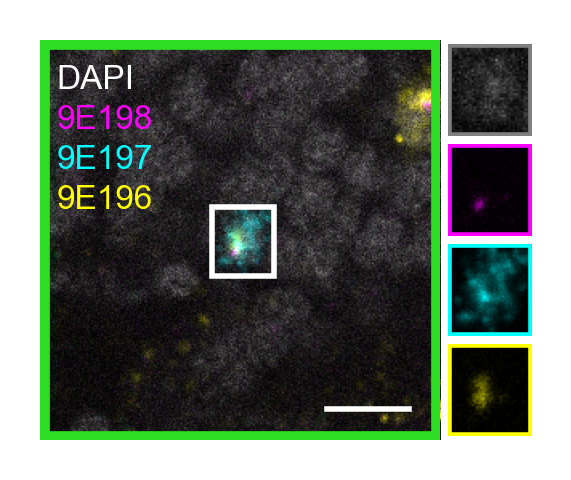

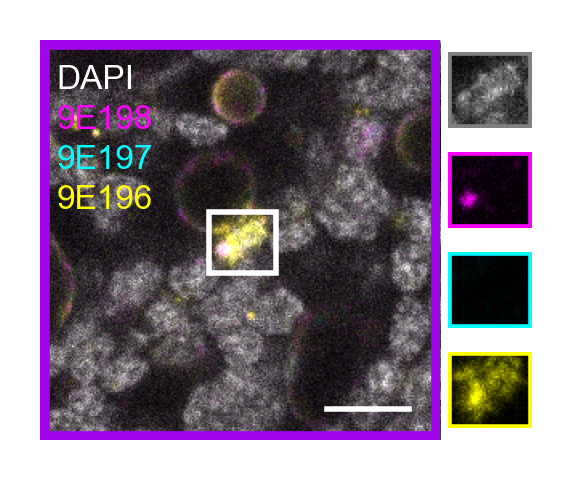

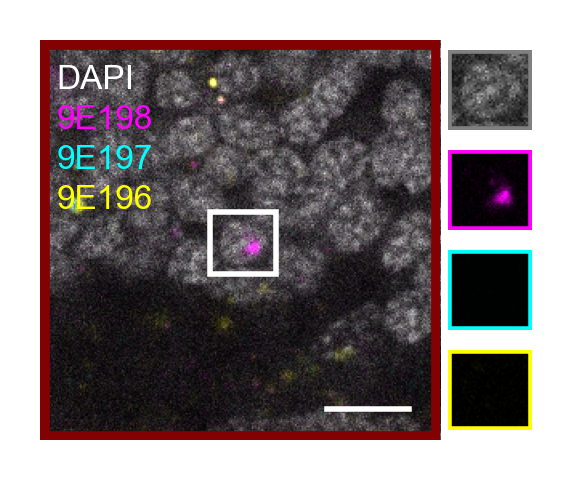

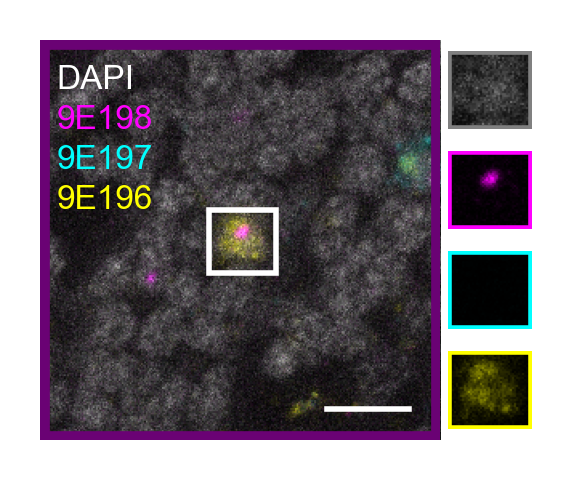

In [79]:
def set_min_max(channel, min_val, max_val):
    if min_val == max_val:
        return np.zeros_like(channel)  # If min == max, return all zeros
    clipped = np.clip(channel, min_val, max_val)
    rescaled = (clipped - min_val) / (max_val - min_val) * 255
    return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

for i, cell in cells.iterrows():
    # Retrieve image and z slice 
    x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
    y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
    cell_image = image_data[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

    # Create composite RGB image
    rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

    # -- DAPI (Grey): add to all channels
    dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
    dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
    rgb_image[..., 0] += dapi_adjusted  # Red
    rgb_image[..., 1] += dapi_adjusted  # Green
    rgb_image[..., 2] += dapi_adjusted  # Blue

    # -- Magenta (AF488): add to red and blue
    c1_index = [idx for idx, channel in channels if "488" in channel][0]
    c1_adjusted = set_min_max(cell_image[c1_index], 0, AF488_max) 
    rgb_image[..., 0] += c1_adjusted  # Red
    rgb_image[..., 2] += c1_adjusted  # Blue

    # -- Cyan (AF546): add to green and blue
    c2_index = [idx for idx, channel in channels if "546" in channel][0]
    c2_adjusted = set_min_max(cell_image[c2_index], 0, AF546_max)
    rgb_image[..., 1] += c2_adjusted  # Green
    rgb_image[..., 2] += c2_adjusted  # Blue

    # -- Yellow (AF647): add to red and green
    c3_index = [idx for idx, channel in channels if "647" in channel][0]
    c3_adjusted = set_min_max(cell_image[c3_index], 0, AF647_max)
    rgb_image[..., 0] += c3_adjusted  # Green
    rgb_image[..., 1] += c3_adjusted  # Blue

    # Normalize composite image to [0,1]
    rgb_image = np.clip(rgb_image/255, 0, 1)

    # Load ROIs and compute bbox (adjusted relative to the cell image)
    regions = regionprops(all_rois[cell['z'], :, :])
    region_labels = [region.label for region in regions]
    region = regions[region_labels.index(cell['z_id'])]
    bbox = region.bbox

    # Expand bbox by bbox_expansion pixels     
    bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
            bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
    # Adjust bbox to cell_image coordinates
    bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
            bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
    # For clarity, unpack bbox (top, left, bottom, right)
    y1, x1, y2, x2 = bbox

    # Create figure with gridspec: main image in left column (spanning all rows) 
    # and three zoom panels in the right column (each taking 1/3 height)
    # Adjust fig size and width ratios as needed.
    fig_width = 1.25   # total width (main image + zoom panels)
    fig_height = 1.0  # height of the main image (zoom panels share this height)
    f = plt.figure(figsize=(fig_width, fig_height), dpi=400, facecolor='white')
    gs = gridspec.GridSpec(nrows=4, ncols=2, width_ratios=[5, 1])
    ax_main = f.add_subplot(gs[:, 0])
    ax_zoom_gray = f.add_subplot(gs[0, 1])
    ax_zoom_magenta = f.add_subplot(gs[1, 1])
    ax_zoom_cyan = f.add_subplot(gs[2, 1])
    ax_zoom_yellow = f.add_subplot(gs[3, 1])

    # Plot main composite image
    ax_main.imshow(rgb_image)
    ax_main.axis("off")
    # Add border to main image
    ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, 
                                    fill=False, edgecolor=cell['color'], lw=3))
    # Add text legends on main image
    ax_main.text(10, 30, "DAPI", color='white', fontsize=6) 
    ax_main.text(10, 55, AF488_name, color='magenta', fontsize=6)
    ax_main.text(10, 80, AF546_name, color='cyan', fontsize=6)
    ax_main.text(10, 105, AF647_name, color='yellow', fontsize=6)

    # Add scale bar on main image
    ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
    
    ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

    # ----- Create zoom panels -----
    # Zoom for Grey (DAPI)
    zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
    # Build RGB image: all channels get the DAPI intensity
    dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
    dapi_zoom[..., 0] = zoom_dapi
    dapi_zoom[..., 1] = zoom_dapi
    dapi_zoom[..., 2] = zoom_dapi
    dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
    ax_zoom_gray.imshow(dapi_zoom)
    ax_zoom_gray.axis("off")
    ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))

    # Zoom for Magenta (c1)
    zoom_c1 = c1_adjusted[y1:y2, x1:x2]
    # Build an RGB image: red and blue channels from c1
    magenta_zoom = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
    magenta_zoom[..., 0] = zoom_c1  # red
    magenta_zoom[..., 2] = zoom_c1  # blue
    magenta_zoom = np.clip(magenta_zoom/255, 0, 1)
    ax_zoom_magenta.imshow(magenta_zoom)
    ax_zoom_magenta.axis("off")
    ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor='magenta', lw=1))

    # Zoom for Cyan (c2)
    zoom_c2 = c2_adjusted[y1:y2, x1:x2]
    # Build an RGB image: green and blue channels from c2
    cyan_zoom = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
    cyan_zoom[..., 1] = zoom_c2  # green
    cyan_zoom[..., 2] = zoom_c2  # blue
    cyan_zoom = np.clip(cyan_zoom/255, 0, 1)
    ax_zoom_cyan.imshow(cyan_zoom)
    ax_zoom_cyan.axis("off")
    ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor='cyan', lw=1))

    # Zoom for Yellow (c3) 
    zoom_c3 = c3_adjusted[y1:y2, x1:x2]
    # Build an RGB image: green and blue channels from c2
    yellow_zoom = np.zeros((zoom_c3.shape[0], zoom_c3.shape[1], 3), dtype=float)
    yellow_zoom[..., 0] = zoom_c3  # green
    yellow_zoom[..., 1] = zoom_c3  # blue
    yellow_zoom = np.clip(yellow_zoom/255, 0, 1)
    ax_zoom_yellow.imshow(yellow_zoom)
    ax_zoom_yellow.axis("off")
    ax_zoom_yellow.add_patch(plt.Rectangle((0, 0), zoom_c3.shape[1]-1, zoom_c3.shape[0]-1, fill=False, edgecolor='yellow', lw=1))

    plt.tight_layout(pad=0)
    #plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{i+1}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
    plt.show()

In [86]:
input = '20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi'
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('.csv')]

# Load all results 
results = pd.DataFrame() 
for f in results_files:
    results_path = os.path.join(results_dir, f)
    results = pd.concat([results, pd.read_csv(results_path)], axis=0) 

results

z_id                                     image   z  count       area  \
0         1  20250325 4 t19 lncrna sample 4 great.czi   4      0   6.453208   
1         3  20250325 4 t19 lncrna sample 4 great.czi   4      1   5.854457   
2         4  20250325 4 t19 lncrna sample 4 great.czi   4      2   6.776344   
3         1  20250325 4 t19 lncrna sample 4 great.czi   5      3   4.476379   
4         2  20250325 4 t19 lncrna sample 4 great.czi   5      4  11.442802   
...     ...                                       ...  ..    ...        ...   
28046     2  20250325 4 t19 lncrna sample 3 great.czi  78  28046   7.270551   
28047     3  20250325 4 t19 lncrna sample 3 great.czi  78  28047   9.019285   
28048     4  20250325 4 t19 lncrna sample 3 great.czi  78  28048   4.077211   
28049     5  20250325 4 t19 lncrna sample 3 great.czi  78  28049   8.154422   
28050     6  20250325 4 t19 lncrna sample 3 great.czi  78  28050   4.713978   

        centroid_x   centroid_y  AF546-T1   AF488-T2  AF647-T3  
0      1004.998527   750.944035  1.901325  19.459499  3.100147  
1      1054.967532   874.316558  1.775974  14.712662  3.461039  
2      1085.605891   884.601683  1.297335  16.039271  2.431978  
3      1005.915074   685.203822  1.963907  15.505308  3.278132  
4       974.251661   697.291528  2.146179  15.357973  3.189369  
...            ...          ...       ...        ...       ...  
28046   886.703268  1618.396078  1.457516  16.525490  2.665359  
28047   961.057956  1625.526870  1.442571  10.267650  2.229715  
28048   972.783217  1652.543124  1.547786  12.468531  2.498834  
28049   916.467366  1658.569930  1.526807  15.131702  2.947552  
28050   952.173387  1672.336694  1.614919  14.318548  2.707661  

[115882 rows x 10 columns]

In [87]:
results.columns = results.columns.str.split('-T').str[0]

In [82]:
file_number = 2
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../raw-data/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 2 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 28262.863006591797, 28655.546295166016), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 76, 4, 2048, 2048)
Loaded ../results/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 2 great_rois.npy


In [102]:
AF488_name, AF546_name, AF647_name = "U34", "PR", "U21"
channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]

In [90]:
# Drop outliers from AF546, AF647, and AF488 columns (extremely large values) 
results = results[results['AF488']<70]

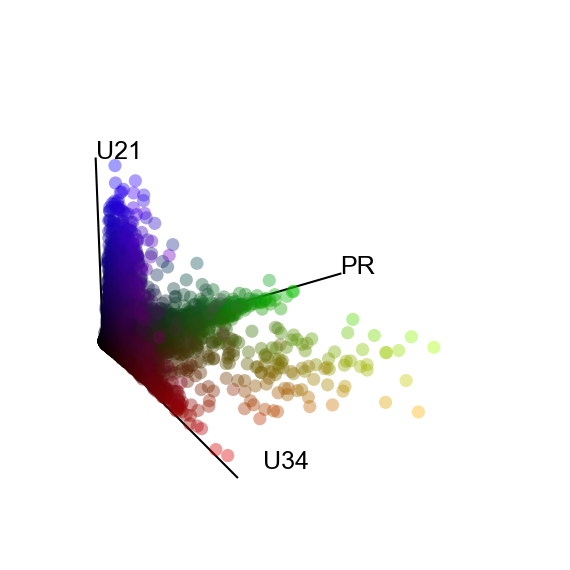

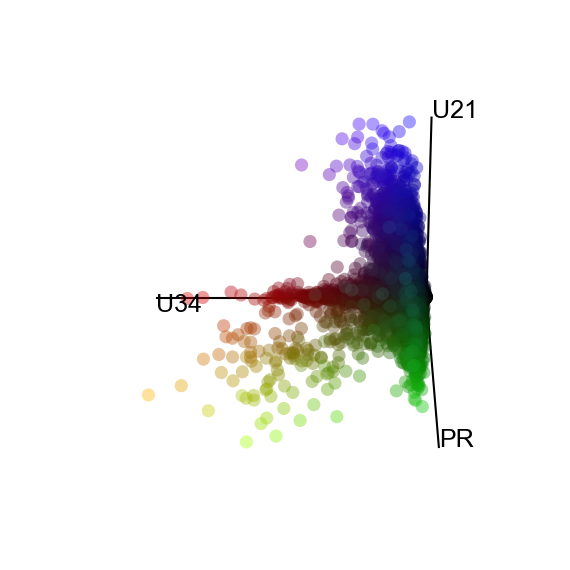

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assume AF488_name, AF546_name, and AF647_name are defined (e.g., "AF488", etc.)

# Normalize each intensity column to the [0, 1] range for natural RGB mapping
results['AF488_norm'] = (results["AF488"] - results["AF488"].min()) / (results["AF488"].max() - results["AF488"].min())
results['AF546_norm'] = (results["AF546"] - results["AF546"].min()) / (results["AF546"].max() - results["AF546"].min())
results['AF647_norm'] = (results["AF647"] - results["AF647"].min()) / (results["AF647"].max() - results["AF647"].min())
results["color"] = np.column_stack((results['AF488_norm'], results['AF546_norm'], results['AF647_norm'])).tolist()

# Optionally, you can also scale your data (if needed for other analysis) but here we use raw intensities for plotting.
# If you have already scaled data for clustering, you might want to keep the original intensity ranges for color.
# In this example, we use the original intensity values for the 3D coordinates.
fig = plt.figure(figsize=(3, 2), dpi=300) 
ax = fig.add_subplot(projection='3d')

# Plot the data using the composite RGB colors
scatter = ax.scatter(results["AF488_norm"], results["AF546_norm"], results["AF647_norm"],
                     c=results["color"], alpha=0.4, s=10, linewidths=0)

ax.text(x=1, y=0.1, z=0, s=AF488_name, fontsize=6)
ax.text(x=0, y=1, z=0, s=AF546_name, fontsize=6)
ax.text(x=0, y=0, z=1, s=AF647_name, fontsize=6)

# Draw axes lines from (0,0,0) to the max of each channel
ax.plot([0, 0], [0, 0], [0, 1], color='black', linewidth=0.5)
ax.plot([0, 0], [0, 1], [0, 0], color='black', linewidth=0.5)
ax.plot([1, 0], [0, 0], [0, 0], color='black', linewidth=0.5)

# Adjust the view so that (0,0,0) appears at the back corner.
ax.view_init(elev=30, azim=-30) 

ax.set_axis_off()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(3, 2), dpi=300) 
ax = fig.add_subplot(projection='3d')

# Plot the data using the composite RGB colors
scatter = ax.scatter(results["AF488_norm"], results["AF546_norm"], results["AF647_norm"],
                     c=results["color"], alpha=0.4, s=10, linewidths=0)

ax.text(x=1, y=0.1, z=0, s=AF488_name, fontsize=6)
ax.text(x=0, y=1, z=0, s=AF546_name, fontsize=6)
ax.text(x=0, y=0, z=1, s=AF647_name, fontsize=6)

# Draw axes lines from (0,0,0) to the max of each channel
ax.plot([0, 0], [0, 0], [0, 1], color='black', linewidth=0.5)
ax.plot([0, 0], [0, 1], [0, 0], color='black', linewidth=0.5)
ax.plot([1, 0], [0, 0], [0, 0], color='black', linewidth=0.5)

# Adjust the view so that (0,0,0) appears at the back corner.
ax.view_init(elev=30, azim=90) 

ax.set_axis_off()

plt.tight_layout()
plt.show()

In [105]:
dapi_max, AF488_max, AF546_max, AF647_max, = 255, 255, 200, 255
pixel_bounds = 125 
bbox_expansion = 5 
x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

In [ ]:

# Coordinates: on the image its up, right, left 
# 9E196, 9E197, 9E198 
coordinates = [[0, 0, 0], 
               [0.8, 0.3, 0], # 
               [0, 0.7, 0.7], # 
               [0.8, 0, 0.2], # 
               [1, 1, 1], 
               [0.5, 0, 0], 
               
               ]
results_image = results[results['image'] == image].reset_index(drop=True)
# For each coordinate in cells_to_plot, find the closest cell in the results_image dataframe, save it to a list
cells = [] 
for coor in coordinates: 
    # Find the closest cell to the coordinate by comparing the Euclidean distance of each cell's coordinates to the target coordinate
    cell_idx = np.argmin(np.linalg.norm(results_image[["AF488_norm", "AF546_norm", "AF647_norm"]].values - coor, axis=1))
    cell = results_image.iloc[cell_idx]
    cells.append(cell)
cells = pd.DataFrame(cells)
cells

z_id                                     image   z  count       area  \
23197   165  20250325 4 t19 lncrna sample 2 great.czi  58  23197   7.070968   
4432    218  20250325 4 t19 lncrna sample 2 great.czi  21   4432   4.143739   
13853   137  20250325 4 t19 lncrna sample 2 great.czi  42  13853  11.233715   
3368     57  20250325 4 t19 lncrna sample 2 great.czi  18   3368   8.582102   
12927   254  20250325 4 t19 lncrna sample 2 great.czi  40  12927   4.837530   
60       19  20250325 4 t19 lncrna sample 2 great.czi   3     60   8.258966   

       centroid_x   centroid_y      AF546      AF488      AF647  AF488_norm  \
23197  808.126344   855.573925   1.147849   3.719086   1.063172    0.003451   
4432   551.020642  1258.075688  20.165138  35.162844   2.474771    0.509196   
13853  709.072758   624.588832  22.018613  21.313029  20.796954    0.286434   
3368   881.592470   695.794020   1.609081  37.819491   2.555925    0.551926   
12927  621.958743   912.253438  50.451866  29.862475   3.257367    0.423944   
60     931.110472  1288.200230   1.906789  35.919448   2.714614    0.521365   

       AF546_norm  AF647_norm  \
23197    0.003890    0.004902   
4432     0.302192    0.026336   
13853    0.331265    0.304552   
3368     0.011125    0.027569   
12927    0.777263    0.038220   
60       0.015795    0.029978   

                                                   color  
23197  [0.003450791821194266, 0.0038904708815721825, ...  
4432   [0.5091960822658315, 0.3021916234734004, 0.026...  
13853  [0.28643394156040647, 0.33126483814377305, 0.3...  
3368   [0.5519259137480702, 0.011125248571578131, 0.0...  
12927  [0.42394429865040617, 0.7772628341499305, 0.03...  
60     [0.5213653881550259, 0.015795042145590552, 0.0...

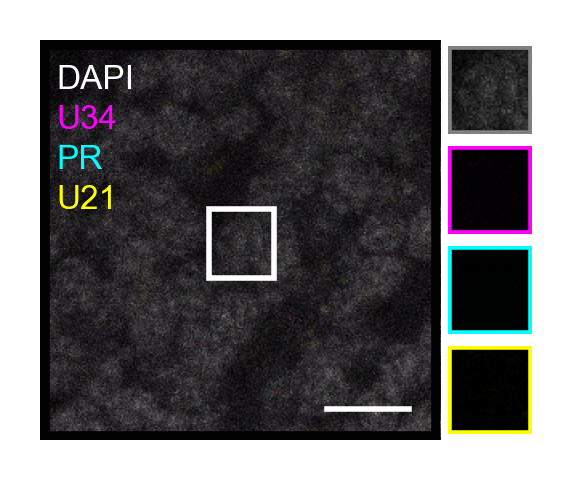

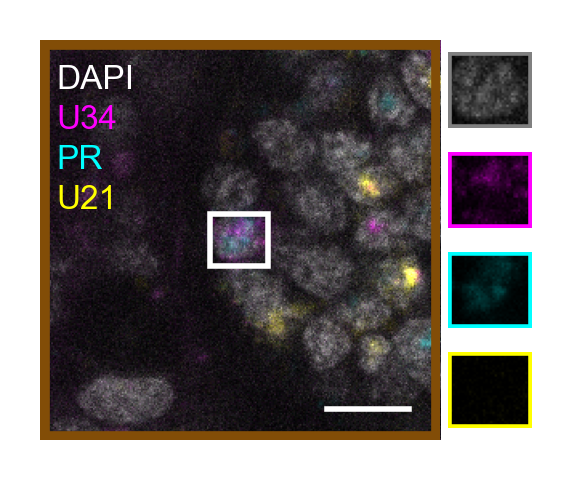

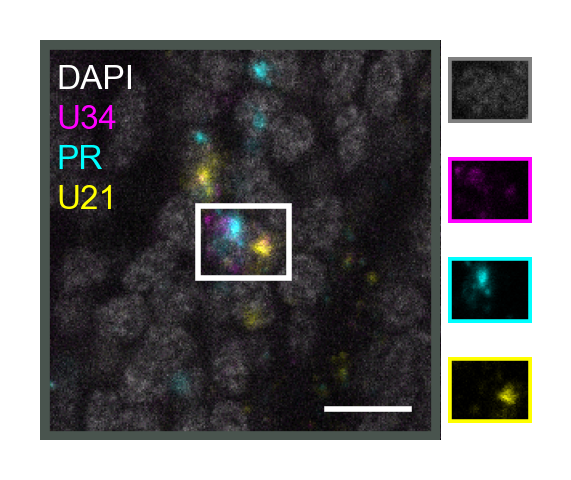

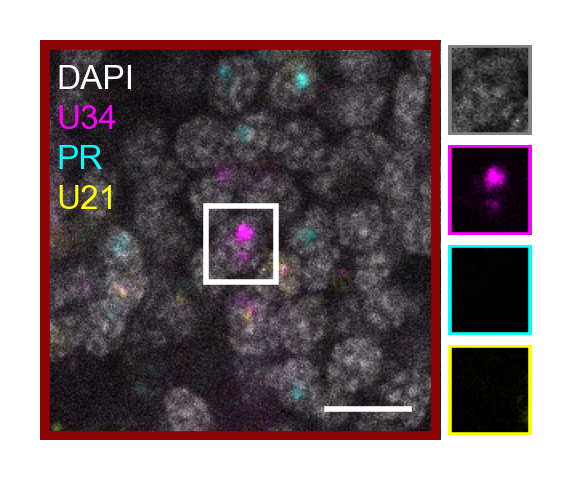

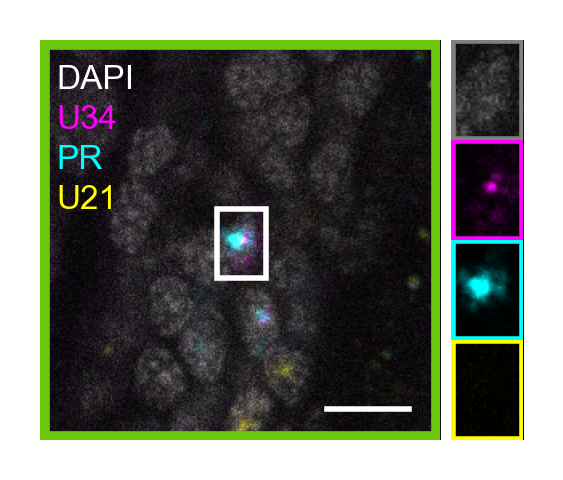

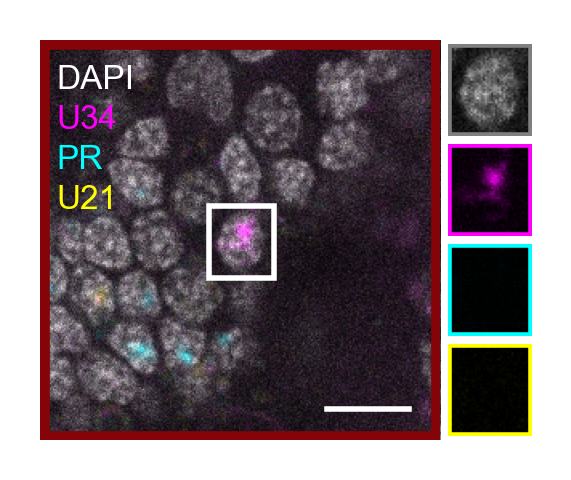

In [107]:
def set_min_max(channel, min_val, max_val):
    if min_val == max_val:
        return np.zeros_like(channel)  # If min == max, return all zeros
    clipped = np.clip(channel, min_val, max_val)
    rescaled = (clipped - min_val) / (max_val - min_val) * 255
    return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

for i, cell in cells.iterrows():
    # Retrieve image and z slice 
    x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
    y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
    cell_image = image_data[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

    # Create composite RGB image
    rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

    # -- DAPI (Grey): add to all channels
    dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
    dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
    rgb_image[..., 0] += dapi_adjusted  # Red
    rgb_image[..., 1] += dapi_adjusted  # Green
    rgb_image[..., 2] += dapi_adjusted  # Blue

    # -- Magenta (AF488): add to red and blue
    c1_index = [idx for idx, channel in channels if "488" in channel][0]
    c1_adjusted = set_min_max(cell_image[c1_index], 0, AF488_max) 
    rgb_image[..., 0] += c1_adjusted  # Red
    rgb_image[..., 2] += c1_adjusted  # Blue

    # -- Cyan (AF546): add to green and blue
    c2_index = [idx for idx, channel in channels if "546" in channel][0]
    c2_adjusted = set_min_max(cell_image[c2_index], 0, AF546_max)
    rgb_image[..., 1] += c2_adjusted  # Green
    rgb_image[..., 2] += c2_adjusted  # Blue

    # -- Yellow (AF647): add to red and green
    c3_index = [idx for idx, channel in channels if "647" in channel][0]
    c3_adjusted = set_min_max(cell_image[c3_index], 0, AF647_max)
    rgb_image[..., 0] += c3_adjusted  # Green
    rgb_image[..., 1] += c3_adjusted  # Blue

    # Normalize composite image to [0,1]
    rgb_image = np.clip(rgb_image/255, 0, 1)

    # Load ROIs and compute bbox (adjusted relative to the cell image)
    regions = regionprops(all_rois[cell['z'], :, :])
    region_labels = [region.label for region in regions]
    region = regions[region_labels.index(cell['z_id'])]
    bbox = region.bbox

    # Expand bbox by bbox_expansion pixels     
    bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
            bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
    # Adjust bbox to cell_image coordinates
    bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
            bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
    # For clarity, unpack bbox (top, left, bottom, right)
    y1, x1, y2, x2 = bbox

    # Create figure with gridspec: main image in left column (spanning all rows) 
    # and three zoom panels in the right column (each taking 1/3 height)
    # Adjust fig size and width ratios as needed.
    fig_width = 1.25   # total width (main image + zoom panels)
    fig_height = 1.0  # height of the main image (zoom panels share this height)
    f = plt.figure(figsize=(fig_width, fig_height), dpi=400, facecolor='white')
    gs = gridspec.GridSpec(nrows=4, ncols=2, width_ratios=[5, 1])
    ax_main = f.add_subplot(gs[:, 0])
    ax_zoom_gray = f.add_subplot(gs[0, 1])
    ax_zoom_magenta = f.add_subplot(gs[1, 1])
    ax_zoom_cyan = f.add_subplot(gs[2, 1])
    ax_zoom_yellow = f.add_subplot(gs[3, 1])

    # Plot main composite image
    ax_main.imshow(rgb_image)
    ax_main.axis("off")
    # Add border to main image
    ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, 
                                    fill=False, edgecolor=cell['color'], lw=3))
    # Add text legends on main image
    ax_main.text(10, 30, "DAPI", color='white', fontsize=6) 
    ax_main.text(10, 55, AF488_name, color='magenta', fontsize=6)
    ax_main.text(10, 80, AF546_name, color='cyan', fontsize=6)
    ax_main.text(10, 105, AF647_name, color='yellow', fontsize=6)

    # Add scale bar on main image
    ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
    
    ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

    # ----- Create zoom panels -----
    # Zoom for Grey (DAPI)
    zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
    # Build RGB image: all channels get the DAPI intensity
    dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
    dapi_zoom[..., 0] = zoom_dapi
    dapi_zoom[..., 1] = zoom_dapi
    dapi_zoom[..., 2] = zoom_dapi
    dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
    ax_zoom_gray.imshow(dapi_zoom)
    ax_zoom_gray.axis("off")
    ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))

    # Zoom for Magenta (c1)
    zoom_c1 = c1_adjusted[y1:y2, x1:x2]
    # Build an RGB image: red and blue channels from c1
    magenta_zoom = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
    magenta_zoom[..., 0] = zoom_c1  # red
    magenta_zoom[..., 2] = zoom_c1  # blue
    magenta_zoom = np.clip(magenta_zoom/255, 0, 1)
    ax_zoom_magenta.imshow(magenta_zoom)
    ax_zoom_magenta.axis("off")
    ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor='magenta', lw=1))

    # Zoom for Cyan (c2)
    zoom_c2 = c2_adjusted[y1:y2, x1:x2]
    # Build an RGB image: green and blue channels from c2
    cyan_zoom = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
    cyan_zoom[..., 1] = zoom_c2  # green
    cyan_zoom[..., 2] = zoom_c2  # blue
    cyan_zoom = np.clip(cyan_zoom/255, 0, 1)
    ax_zoom_cyan.imshow(cyan_zoom)
    ax_zoom_cyan.axis("off")
    ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor='cyan', lw=1))

    # Zoom for Yellow (c3) 
    zoom_c3 = c3_adjusted[y1:y2, x1:x2]
    # Build an RGB image: green and blue channels from c2
    yellow_zoom = np.zeros((zoom_c3.shape[0], zoom_c3.shape[1], 3), dtype=float)
    yellow_zoom[..., 0] = zoom_c3  # green
    yellow_zoom[..., 1] = zoom_c3  # blue
    yellow_zoom = np.clip(yellow_zoom/255, 0, 1)
    ax_zoom_yellow.imshow(yellow_zoom)
    ax_zoom_yellow.axis("off")
    ax_zoom_yellow.add_patch(plt.Rectangle((0, 0), zoom_c3.shape[1]-1, zoom_c3.shape[0]-1, fill=False, edgecolor='yellow', lw=1))

    plt.tight_layout(pad=0)
    #plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{i+1}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
    plt.show()

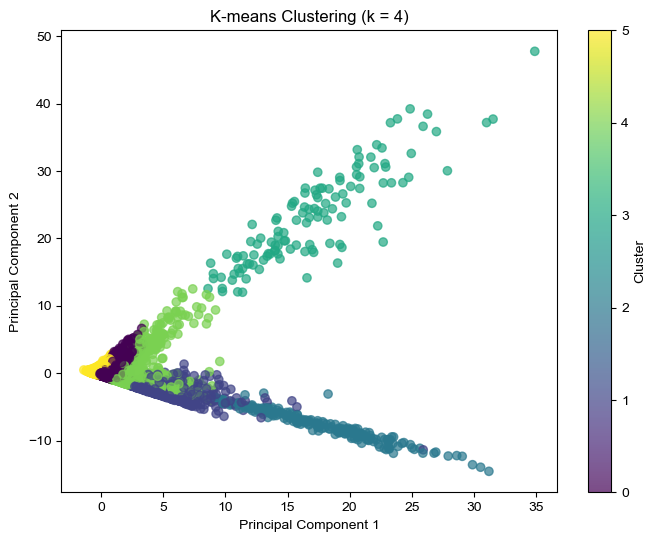

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

intensity_cols = ["AF488", "AF546", "AF647"]
# Extract the intensity data from the dataframe
X = results[intensity_cols].values

# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set the number of clusters (e.g., 4 based on your 4 biological samples)
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original dataframe
results['cluster'] = clusters

# Reduce the dimensions to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-means Clustering (k = 4)")
plt.colorbar(scatter, label='Cluster')
plt.show()

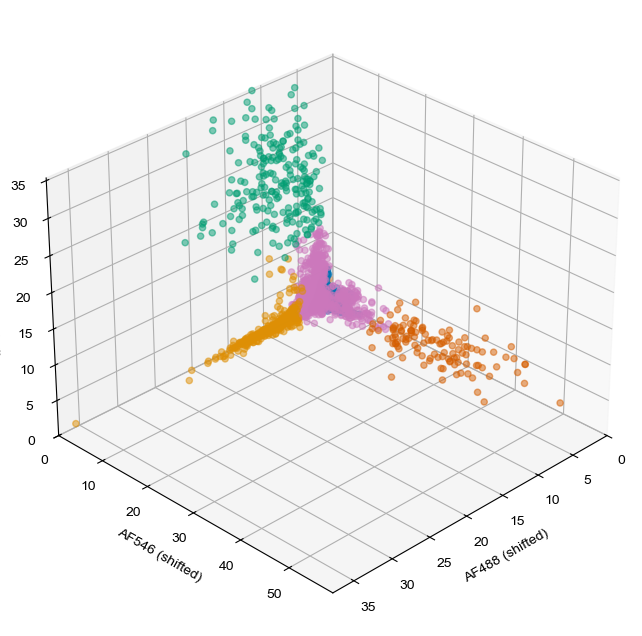

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

intensity_cols = ["AF488", "AF546", "AF647"]
# Extract the intensity data from the dataframe
X = results[intensity_cols].values

# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set the number of clusters (e.g., 5 clusters)
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original dataframe
results['cluster'] = clusters

# For visualization only: shift the data so that the minimum along each axis is 0.
# This makes (0,0,0) a corner of your bounding box.
X_plot = X_scaled - X_scaled.min(axis=0)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Set axes limits based on the shifted data
ax.set_xlim(0, X_plot[:, 0].max())
ax.set_ylim(0, X_plot[:, 1].max())
ax.set_zlim(0, X_plot[:, 2].max())

random_colors = sns.color_palette('colorblind', num_clusters)
cmap = ListedColormap(random_colors)
scatter = ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2],
                     c=clusters, cmap=cmap, alpha=0.5)

ax.set_xlabel("AF488 (shifted)")
ax.set_ylabel("AF546 (shifted)")
ax.set_zlabel("AF647 (shifted)")

# Adjust the view so that (0,0,0) appears at the back corner.
# Viewing from the direction of the positive axes (e.g., elev=30, azim=45)
# will show the (0,0,0) corner as the farthest point.
ax.view_init(elev=30, azim=45)

plt.show()


In [ ]:
"""results_image = results[results['image'] == image].reset_index(drop=True)

# Choose a random cell for each cluster 
np.random.seed(2) 
random_cell_indices = results_image.groupby('cluster').apply(lambda x: x.sample(1)).index
random_cell_indices = random_cell_indices.get_level_values(1)
random_cells = results_image.loc[random_cell_indices].reset_index(drop=True)
random_cells"""

"results_image = results[results['image'] == image].reset_index(drop=True)\n\n# Choose a random cell for each cluster \nnp.random.seed(2) \nrandom_cell_indices = results_image.groupby('cluster').apply(lambda x: x.sample(1)).index\nrandom_cell_indices = random_cell_indices.get_level_values(1)\nrandom_cells = results_image.loc[random_cell_indices].reset_index(drop=True)\nrandom_cells"

In [ ]:
input = '20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi'
file_number = 0
input_dir = f'../raw-data/{input}/'
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")
print(czi_files)
# Load single results file  
results_dir = f'../results/{input}'
file = czi_files[file_number]

# Load results 
results = pd.read_csv(os.path.join(results_dir, file.replace('.czi', '.csv')))
print(f"Loaded results for {file}")

# Load image 
file_path = os.path.join(input_dir, file)
reader = napari_get_reader(file_path)
if reader is not None:
    layer_data = reader(file_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {file_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = os.path.join(results_dir, file.replace('.czi', '_rois.npy'))
all_rois = np.load(all_rois_path)
print(f"Loaded ROIs for {file}")

Found 4 czi files in ../raw-data/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/
['20250325 5 t35 sample 4 great.czi', '20250325 5 t35 sample 3 great.czi', '20250325 5 t35 sample 2 great.czi', '20250325 5 t35 sample 1 great.czi']
Loaded results for 20250325 5 t35 sample 4 great.czi
Loaded ../raw-data/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 4 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 102, 4, 2048, 2048)
Loaded ROIs for 20250325 5 t35 sample 4 great.czi
